In [1]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2 as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix)
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [3]:
class DynamicGraphAttention(nn.Module):
    def __init__(self, in_channels, num_nodes=32, heads=8, dropout=0.1):  # Tăng num_nodes/heads mặc định
        super().__init__()
        self.num_nodes = num_nodes
        self.heads = heads
        self.head_dim = in_channels // heads
        self.dropout = nn.Dropout(dropout)

        self.query = nn.Linear(in_channels, in_channels)
        self.key = nn.Linear(in_channels, in_channels)
        self.value = nn.Linear(in_channels, in_channels)
        self.out = nn.Linear(in_channels, in_channels)
        self.scale = nn.Parameter(torch.tensor(self.head_dim**-0.5))

        # Positional encoding (simple learnable)
        self.pos_enc = nn.Parameter(torch.randn(1, num_nodes, in_channels))

    def forward(self, x):
        B, C, H, W = x.size()
        x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        
        num_pixels = H * W
        N = min(self.num_nodes, num_pixels)
        
        # Importance sampling: Chọn top-k pixels dựa trên L2 norm (thay vì random/linspace)
        norms = torch.norm(x_flat, dim=-1)  # (B, H*W)
        _, indices = torch.topk(norms, N, dim=-1)  # Top-k indices
        indices = indices.sort(dim=-1).indices  # Sort để ổn định
        x_nodes = torch.gather(x_flat, 1, indices.unsqueeze(-1).expand(-1, -1, C))  # (B, N, C)
        
        # Thêm positional encoding
        x_nodes = x_nodes + self.pos_enc.expand(B, -1, -1)
        
        q = self.query(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        k = self.key(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        v = self.value(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)  # Thêm dropout
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, N, C)
        
        out_nodes = self.out(attn_output)
        
        out_flat = torch.zeros_like(x_flat)
        out_flat.scatter_(1, indices.unsqueeze(-1).expand(-1, -1, C), out_nodes)
        out = out_flat.transpose(1, 2).view(B, C, H, W)
        
        return x + out  # Residual connection

class TemporalAttentionAggregator(nn.Module):
    def __init__(self, in_channels, num_heads=4):
        super().__init__()
        self.attention_net = nn.MultiheadAttention(embed_dim=in_channels, num_heads=num_heads)  # Thay MLP bằng MultiheadAttention
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        if len(x.shape) == 4:  # (B, C, H, W) -> Giả sử single frame, flatten spatial
            B, C, H, W = x.size()
            x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        elif len(x.shape) == 5:  # (B, T, C, H, W) -> Flatten temporal-spatial
            B, T, C, H, W = x.size()
            x_flat = x.flatten(3).transpose(2, 3).reshape(B, T * H * W, C)  # (B, T*H*W, C)
        else:
            raise ValueError("Input must be 4D or 5D tensor")
        
        # Temporal-spatial attention
        x_flat = self.norm(x_flat)
        attn_output, _ = self.attention_net(x_flat, x_flat, x_flat)  # Self-attention
        
        # Aggregate
        aggregated_vector = torch.mean(attn_output, dim=1)  # Mean pooling thay sum để ổn định
        return aggregated_vector

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion=6):  # Tăng expansion mặc định
        super().__init__()
        hidden_dim = in_channels * expansion
        self.use_residual = in_channels == out_channels and stride == 1
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),  # Thay ReLU6 bằng SiLU (Swish)
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        # Thêm SE block
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 16, 1),
            nn.SiLU(),
            nn.Conv2d(out_channels // 16, out_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.conv(x)
        out = out * self.se(out)  # Áp dụng SE
        return x + out if self.use_residual else out

In [4]:
class PestLarvaNet_Medium(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super().__init__()
        self.config = [[1, 24, 2, 1], [6, 40, 3, 2], [6, 64, 3, 2], [6, 120, 3, 2], [6, 160, 2, 1]]
        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 24, 3, 2, 1, bias=False),
            nn.BatchNorm2d(24), nn.SiLU(inplace=True))
        
        layers = []
        in_channels = 24
        for t, c, n, s in self.config:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(in_channels, c, stride, expansion=t))
                in_channels = c
            if c == 40:
                layers.append(DynamicGraphAttention(in_channels, num_nodes=32, heads=8))
        self.body = nn.Sequential(*layers)
        
        self.head_conv = nn.Conv2d(160, 384, 1, bias=False)
        self.aggregator = TemporalAttentionAggregator(384, num_heads=8)
        self.classifier = nn.Sequential(
            nn.Linear(384, 192), nn.SiLU(inplace=True), nn.Dropout(0.4),
            nn.Linear(192, num_classes))
            
    def forward(self, x):
        x = self.stem(x); x = self.body(x); x = self.head_conv(x)
        x = self.aggregator(x); x = self.classifier(x); return x

In [5]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [6]:
class InsectSpectrogramDataset(Dataset):
    """Dataset tùy chỉnh để đọc các file spectrogram .pt"""
    def __init__(self, metadata_file, data_dir, transform=None):
        self.metadata = pd.read_csv(metadata_file)
        self.data_dir = data_dir
        self.transform = transform
        self.file_column = 'file_name'
        self.label_column = 'label'
        
        self.class_names = sorted(self.metadata[self.label_column].unique())
        self.class_to_id = {name: i for i, name in enumerate(self.class_names)}
        self.id_to_class = {i: name for name, i in self.class_to_id.items()}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        file_name = self.metadata.iloc[idx][self.file_column]
        file_path = os.path.join(self.data_dir, file_name)
        label_name = self.metadata.iloc[idx][self.label_column]
        label = self.class_to_id[label_name]
        
        try:
            spectrogram = torch.load(file_path)
            if spectrogram.dim() == 2:
                spectrogram = spectrogram.unsqueeze(0)
            if self.transform:
                spectrogram = self.transform(spectrogram)
            return spectrogram, label
        except Exception as e:
            print(f"Lỗi khi tải file {file_path}: {e}")
            return torch.zeros(1, 128, 259), -1 # Trả về mẫu lỗi

In [7]:
METADATA_PATH = r'D:\Dataset\metadata_Mel.csv' 
DATA_DIR = r'D:\Dataset\MelSpectrograms'

In [8]:
class TimeShift(torch.nn.Module):
    """ Dịch chuyển spectrogram theo trục thời gian một cách ngẫu nhiên. """
    def __init__(self, p=0.5, max_shift_percent=0.4):
        super().__init__()
        self.p = p
        self.max_shift_percent = max_shift_percent

    def forward(self, spec):
        if torch.rand(1) < self.p:
            time_steps = spec.shape[-1]
            # Chọn một lượng dịch chuyển ngẫu nhiên
            shift_amount = int(torch.rand(1) * self.max_shift_percent * time_steps)
            # Dịch ngẫu nhiên sang trái hoặc phải
            if torch.rand(1) < 0.5:
                shift_amount = -shift_amount
            return torch.roll(spec, shifts=shift_amount, dims=-1)
        return spec

class SpecNoise(torch.nn.Module):
    """ Thêm nhiễu Gaussian trực tiếp vào spectrogram. """
    def __init__(self, p=0.5, noise_level=0.05):
        super().__init__()
        self.p = p
        self.noise_level = noise_level

    def forward(self, spec):
        if torch.rand(1) < self.p:
            noise = torch.randn_like(spec) * self.noise_level
            return spec + noise
        return spec

In [9]:
train_transform = T.Compose([
    # Kỹ thuật 1: SpecAugment (Time & Frequency Masking)
    torchaudio.transforms.TimeMasking(time_mask_param=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=25),
    
    # Kỹ thuật 2: Time Shifting
    TimeShift(p=0.5, max_shift_percent=0.4),
    
    # Kỹ thuật 3: Spectrogram Noise
    SpecNoise(p=0.3, noise_level=0.03),
])

# Tập validation không sử dụng augmentation
val_transform = None

print("Đã định nghĩa xong pipeline Augmentation cho Spectrogram.")

Đã định nghĩa xong pipeline Augmentation cho Spectrogram.


In [10]:
def mixup_data(x, y, alpha=0.4, use_cuda=True):
    """
    Trộn dữ liệu trong một batch.
    Trả về input đã trộn, và hai bộ nhãn gốc cùng với hệ số trộn lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Hàm tính loss đặc biệt cho Mixup.
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [11]:
if not os.path.exists(METADATA_PATH) or not os.path.isdir(DATA_DIR):
    print("!!! LỖI: Vui lòng kiểm tra lại đường dẫn METADATA_PATH và DATA_DIR.")
else:
    full_dataset = InsectSpectrogramDataset(METADATA_PATH, DATA_DIR)
    num_classes = len(full_dataset.class_names)
    print(f"Tải dữ liệu thành công: {len(full_dataset)} mẫu, {num_classes} lớp.")

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator)

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Tải dữ liệu thành công: 165982 mẫu, 12 lớp.


In [12]:
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

CHECKPOINT_DIR = r'D:/Dataset/checkpoints_medium'
LOG_CSV_PATH = r'D:/Dataset/training_log_medium.csv'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [14]:
model = PestLarvaNet_Medium(num_classes=num_classes).to(device)
total_params, _ = count_parameters(model)
print(f"Khởi tạo mô hình PestLarvaNet-GMA với {total_params/1e6:.2f}M tham số.")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Khởi tạo mô hình PestLarvaNet-GMA với 1.92M tham số.


In [15]:
log_header = [
    'epoch', 'train_loss', 'val_loss', 'learning_rate', 'accuracy',
    'macro_f1', 'weighted_f1', 
    'precision_micro', # Thay thế 'macro_precision', 'weighted_precision'
    'recall_micro'     # Thay thế 'macro_recall', 'weighted_recall'
]
# --- KẾT THÚC THAY ĐỔI ---

with open(LOG_CSV_PATH, 'w', newline='', encoding='utf-8') as f:
    csv.writer(f).writerow(log_header)

print(f"\nBắt đầu huấn luyện... Checkpoints sẽ được lưu tại '{CHECKPOINT_DIR}' và log tại '{LOG_CSV_PATH}'")

# --- Vòng lặp huấn luyện chính ---
best_val_f1 = 0.0


Bắt đầu huấn luyện... Checkpoints sẽ được lưu tại 'D:/Dataset/checkpoints_medium' và log tại 'D:/Dataset/training_log_medium.csv'


In [16]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    
    for inputs, labels in progress_bar:
        if -1 in labels: continue # Bỏ qua các mẫu bị lỗi
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Áp dụng Mixup với xác suất 50%
        if torch.rand(1).item() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            # Chạy như bình thường nếu không dùng Mixup
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            if -1 in labels: continue
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    
    # --- THAY ĐỔI Ở ĐÂY ---
    # Giữ nguyên F1-score với 2 phiên bản
    accuracy = accuracy_score(val_labels, val_preds)
    macro_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    weighted_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
    
    # Tính Precision và Recall phiên bản tổng thể (micro)
    precision = precision_score(val_labels, val_preds, average='micro', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='micro', zero_division=0)
    # --- KẾT THÚC THAY ĐỔI ---
    
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()

    # In kết quả ra màn hình
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f} | Weighted F1: {weighted_f1:.4f}")
    # Thêm dòng in cho Precision và Recall tổng thể
    print(f"  Precision (Micro): {precision:.4f} | Recall (Micro): {recall:.4f}") 
    print(f"  Learning Rate: {current_lr:.6f}")

    # --- THAY ĐỔI Ở ĐÂY ---
    # Lưu vào file CSV
    log_data = [
        epoch + 1, epoch_train_loss, epoch_val_loss, current_lr, accuracy,
        macro_f1, weighted_f1, 
        precision, # Thay thế các phiên bản macro/weighted
        recall     # Thay thế các phiên bản macro/weighted
    ]
    # --- KẾT THÚC THAY ĐỔI ---

    with open(LOG_CSV_PATH, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(log_data)
        
    # Lưu Checkpoint mỗi epoch
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)

    # Lưu lại model tốt nhất (dựa trên weighted F1-score)
    if weighted_f1 > best_val_f1:
        best_val_f1 = weighted_f1
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"  => 🎉 New best model saved to '{best_model_path}' (Weighted F1: {best_val_f1:.4f})\n")

print("\n✅ Hoàn tất huấn luyện!")

Epoch 1/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 1/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 1/100 Summary ---
  Train Loss: 1.4560 | Val Loss: 1.6877
  Accuracy: 0.4630 | Weighted F1: 0.4561
  Precision (Micro): 0.4630 | Recall (Micro): 0.4630
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.4561)



Epoch 2/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 2/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 2/100 Summary ---
  Train Loss: 1.1982 | Val Loss: 0.9361
  Accuracy: 0.6741 | Weighted F1: 0.6644
  Precision (Micro): 0.6741 | Recall (Micro): 0.6741
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.6644)



Epoch 3/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 3/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 3/100 Summary ---
  Train Loss: 1.0580 | Val Loss: 1.1086
  Accuracy: 0.6317 | Weighted F1: 0.6174
  Precision (Micro): 0.6317 | Recall (Micro): 0.6317
  Learning Rate: 0.000999


Epoch 4/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 4/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 4/100 Summary ---
  Train Loss: 0.9640 | Val Loss: 0.8571
  Accuracy: 0.7019 | Weighted F1: 0.6971
  Precision (Micro): 0.7019 | Recall (Micro): 0.7019
  Learning Rate: 0.000998
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.6971)



Epoch 5/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 5/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 5/100 Summary ---
  Train Loss: 0.8741 | Val Loss: 0.6510
  Accuracy: 0.7782 | Weighted F1: 0.7767
  Precision (Micro): 0.7782 | Recall (Micro): 0.7782
  Learning Rate: 0.000996
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.7767)



Epoch 6/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 6/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 6/100 Summary ---
  Train Loss: 0.8117 | Val Loss: 0.5551
  Accuracy: 0.8115 | Weighted F1: 0.8066
  Precision (Micro): 0.8115 | Recall (Micro): 0.8115
  Learning Rate: 0.000994
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.8066)



Epoch 7/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 7/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 7/100 Summary ---
  Train Loss: 0.7592 | Val Loss: 0.4688
  Accuracy: 0.8352 | Weighted F1: 0.8322
  Precision (Micro): 0.8352 | Recall (Micro): 0.8352
  Learning Rate: 0.000991
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.8322)



Epoch 8/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 8/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 8/100 Summary ---
  Train Loss: 0.7162 | Val Loss: 0.8571
  Accuracy: 0.7372 | Weighted F1: 0.7334
  Precision (Micro): 0.7372 | Recall (Micro): 0.7372
  Learning Rate: 0.000988


Epoch 9/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 9/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 9/100 Summary ---
  Train Loss: 0.6647 | Val Loss: 0.6207
  Accuracy: 0.7975 | Weighted F1: 0.7998
  Precision (Micro): 0.7975 | Recall (Micro): 0.7975
  Learning Rate: 0.000984


Epoch 10/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 10/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 10/100 Summary ---
  Train Loss: 0.6474 | Val Loss: 0.3662
  Accuracy: 0.8752 | Weighted F1: 0.8728
  Precision (Micro): 0.8752 | Recall (Micro): 0.8752
  Learning Rate: 0.000980
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.8728)



Epoch 11/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 11/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 11/100 Summary ---
  Train Loss: 0.6089 | Val Loss: 0.4843
  Accuracy: 0.8387 | Weighted F1: 0.8348
  Precision (Micro): 0.8387 | Recall (Micro): 0.8387
  Learning Rate: 0.000976


Epoch 12/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 12/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 12/100 Summary ---
  Train Loss: 0.5998 | Val Loss: 0.6300
  Accuracy: 0.8040 | Weighted F1: 0.8037
  Precision (Micro): 0.8040 | Recall (Micro): 0.8040
  Learning Rate: 0.000970


Epoch 13/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 13/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 13/100 Summary ---
  Train Loss: 0.5865 | Val Loss: 0.3301
  Accuracy: 0.8878 | Weighted F1: 0.8869
  Precision (Micro): 0.8878 | Recall (Micro): 0.8878
  Learning Rate: 0.000965
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.8869)



Epoch 14/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 14/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 14/100 Summary ---
  Train Loss: 0.5674 | Val Loss: 0.5097
  Accuracy: 0.8367 | Weighted F1: 0.8382
  Precision (Micro): 0.8367 | Recall (Micro): 0.8367
  Learning Rate: 0.000959


Epoch 15/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 15/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 15/100 Summary ---
  Train Loss: 0.5533 | Val Loss: 0.3134
  Accuracy: 0.8921 | Weighted F1: 0.8912
  Precision (Micro): 0.8921 | Recall (Micro): 0.8921
  Learning Rate: 0.000952
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.8912)



Epoch 16/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 16/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 16/100 Summary ---
  Train Loss: 0.5437 | Val Loss: 0.3221
  Accuracy: 0.8938 | Weighted F1: 0.8935
  Precision (Micro): 0.8938 | Recall (Micro): 0.8938
  Learning Rate: 0.000946
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.8935)



Epoch 17/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 17/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 17/100 Summary ---
  Train Loss: 0.5281 | Val Loss: 0.3728
  Accuracy: 0.8762 | Weighted F1: 0.8770
  Precision (Micro): 0.8762 | Recall (Micro): 0.8762
  Learning Rate: 0.000938


Epoch 18/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 18/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 18/100 Summary ---
  Train Loss: 0.5187 | Val Loss: 0.3084
  Accuracy: 0.8954 | Weighted F1: 0.8956
  Precision (Micro): 0.8954 | Recall (Micro): 0.8954
  Learning Rate: 0.000930
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.8956)



Epoch 19/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 19/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 19/100 Summary ---
  Train Loss: 0.4960 | Val Loss: 0.3984
  Accuracy: 0.8727 | Weighted F1: 0.8732
  Precision (Micro): 0.8727 | Recall (Micro): 0.8727
  Learning Rate: 0.000922


Epoch 20/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 20/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 20/100 Summary ---
  Train Loss: 0.4878 | Val Loss: 0.4446
  Accuracy: 0.8527 | Weighted F1: 0.8498
  Precision (Micro): 0.8527 | Recall (Micro): 0.8527
  Learning Rate: 0.000914


Epoch 21/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 21/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 21/100 Summary ---
  Train Loss: 0.4885 | Val Loss: 0.2860
  Accuracy: 0.9040 | Weighted F1: 0.9040
  Precision (Micro): 0.9040 | Recall (Micro): 0.9040
  Learning Rate: 0.000905
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9040)



Epoch 22/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 22/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 22/100 Summary ---
  Train Loss: 0.4676 | Val Loss: 0.2980
  Accuracy: 0.9051 | Weighted F1: 0.9050
  Precision (Micro): 0.9051 | Recall (Micro): 0.9051
  Learning Rate: 0.000895
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9050)



Epoch 23/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 23/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 23/100 Summary ---
  Train Loss: 0.4584 | Val Loss: 0.5934
  Accuracy: 0.8195 | Weighted F1: 0.8256
  Precision (Micro): 0.8195 | Recall (Micro): 0.8195
  Learning Rate: 0.000885


Epoch 24/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 24/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 24/100 Summary ---
  Train Loss: 0.4375 | Val Loss: 0.4047
  Accuracy: 0.8819 | Weighted F1: 0.8823
  Precision (Micro): 0.8819 | Recall (Micro): 0.8819
  Learning Rate: 0.000875


Epoch 25/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 25/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 25/100 Summary ---
  Train Loss: 0.4314 | Val Loss: 0.3282
  Accuracy: 0.8946 | Weighted F1: 0.8940
  Precision (Micro): 0.8946 | Recall (Micro): 0.8946
  Learning Rate: 0.000864


Epoch 26/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 26/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 26/100 Summary ---
  Train Loss: 0.4281 | Val Loss: 0.3142
  Accuracy: 0.9057 | Weighted F1: 0.9059
  Precision (Micro): 0.9057 | Recall (Micro): 0.9057
  Learning Rate: 0.000854
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9059)



Epoch 27/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 27/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 27/100 Summary ---
  Train Loss: 0.4196 | Val Loss: 0.4530
  Accuracy: 0.8659 | Weighted F1: 0.8671
  Precision (Micro): 0.8659 | Recall (Micro): 0.8659
  Learning Rate: 0.000842


Epoch 28/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 28/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 28/100 Summary ---
  Train Loss: 0.4116 | Val Loss: 0.5270
  Accuracy: 0.8447 | Weighted F1: 0.8409
  Precision (Micro): 0.8447 | Recall (Micro): 0.8447
  Learning Rate: 0.000831


Epoch 29/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 29/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 29/100 Summary ---
  Train Loss: 0.4119 | Val Loss: 0.5623
  Accuracy: 0.8579 | Weighted F1: 0.8548
  Precision (Micro): 0.8579 | Recall (Micro): 0.8579
  Learning Rate: 0.000819


Epoch 30/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 30/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 30/100 Summary ---
  Train Loss: 0.4127 | Val Loss: 0.3211
  Accuracy: 0.9061 | Weighted F1: 0.9058
  Precision (Micro): 0.9061 | Recall (Micro): 0.9061
  Learning Rate: 0.000806


Epoch 31/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 31/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 31/100 Summary ---
  Train Loss: 0.4009 | Val Loss: 0.3227
  Accuracy: 0.9043 | Weighted F1: 0.9040
  Precision (Micro): 0.9043 | Recall (Micro): 0.9043
  Learning Rate: 0.000794


Epoch 32/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 32/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 32/100 Summary ---
  Train Loss: 0.3860 | Val Loss: 0.3903
  Accuracy: 0.8932 | Weighted F1: 0.8912
  Precision (Micro): 0.8932 | Recall (Micro): 0.8932
  Learning Rate: 0.000781


Epoch 33/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 33/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 33/100 Summary ---
  Train Loss: 0.3975 | Val Loss: 0.3349
  Accuracy: 0.9039 | Weighted F1: 0.9039
  Precision (Micro): 0.9039 | Recall (Micro): 0.9039
  Learning Rate: 0.000768


Epoch 34/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 34/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 34/100 Summary ---
  Train Loss: 0.3884 | Val Loss: 0.3424
  Accuracy: 0.9048 | Weighted F1: 0.9043
  Precision (Micro): 0.9048 | Recall (Micro): 0.9048
  Learning Rate: 0.000755


Epoch 35/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 35/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 35/100 Summary ---
  Train Loss: 0.3695 | Val Loss: 0.3116
  Accuracy: 0.9106 | Weighted F1: 0.9104
  Precision (Micro): 0.9106 | Recall (Micro): 0.9106
  Learning Rate: 0.000741
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9104)



Epoch 36/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 36/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 36/100 Summary ---
  Train Loss: 0.3758 | Val Loss: 0.3282
  Accuracy: 0.9104 | Weighted F1: 0.9105
  Precision (Micro): 0.9104 | Recall (Micro): 0.9104
  Learning Rate: 0.000727
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9105)



Epoch 37/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 37/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 37/100 Summary ---
  Train Loss: 0.3739 | Val Loss: 0.3159
  Accuracy: 0.9131 | Weighted F1: 0.9128
  Precision (Micro): 0.9131 | Recall (Micro): 0.9131
  Learning Rate: 0.000713
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9128)



Epoch 38/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 38/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 38/100 Summary ---
  Train Loss: 0.3834 | Val Loss: 0.3307
  Accuracy: 0.9131 | Weighted F1: 0.9122
  Precision (Micro): 0.9131 | Recall (Micro): 0.9131
  Learning Rate: 0.000699


Epoch 39/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 39/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 39/100 Summary ---
  Train Loss: 0.3701 | Val Loss: 0.3419
  Accuracy: 0.9092 | Weighted F1: 0.9092
  Precision (Micro): 0.9092 | Recall (Micro): 0.9092
  Learning Rate: 0.000684


Epoch 40/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 40/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 40/100 Summary ---
  Train Loss: 0.3582 | Val Loss: 0.4955
  Accuracy: 0.8553 | Weighted F1: 0.8570
  Precision (Micro): 0.8553 | Recall (Micro): 0.8553
  Learning Rate: 0.000669


Epoch 41/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 41/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 41/100 Summary ---
  Train Loss: 0.3546 | Val Loss: 0.4825
  Accuracy: 0.8769 | Weighted F1: 0.8774
  Precision (Micro): 0.8769 | Recall (Micro): 0.8769
  Learning Rate: 0.000655


Epoch 42/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 42/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 42/100 Summary ---
  Train Loss: 0.3472 | Val Loss: 0.3421
  Accuracy: 0.9127 | Weighted F1: 0.9121
  Precision (Micro): 0.9127 | Recall (Micro): 0.9127
  Learning Rate: 0.000639


Epoch 43/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 43/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 43/100 Summary ---
  Train Loss: 0.3531 | Val Loss: 0.4758
  Accuracy: 0.8823 | Weighted F1: 0.8810
  Precision (Micro): 0.8823 | Recall (Micro): 0.8823
  Learning Rate: 0.000624


Epoch 44/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 44/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 44/100 Summary ---
  Train Loss: 0.3418 | Val Loss: 0.3277
  Accuracy: 0.9153 | Weighted F1: 0.9151
  Precision (Micro): 0.9153 | Recall (Micro): 0.9153
  Learning Rate: 0.000609
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9151)



Epoch 45/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 45/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 45/100 Summary ---
  Train Loss: 0.3333 | Val Loss: 0.3531
  Accuracy: 0.9174 | Weighted F1: 0.9175
  Precision (Micro): 0.9174 | Recall (Micro): 0.9174
  Learning Rate: 0.000594
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9175)



Epoch 46/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 46/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 46/100 Summary ---
  Train Loss: 0.3405 | Val Loss: 0.3183
  Accuracy: 0.9162 | Weighted F1: 0.9158
  Precision (Micro): 0.9162 | Recall (Micro): 0.9162
  Learning Rate: 0.000578


Epoch 47/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 47/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 47/100 Summary ---
  Train Loss: 0.3372 | Val Loss: 0.3391
  Accuracy: 0.9135 | Weighted F1: 0.9139
  Precision (Micro): 0.9135 | Recall (Micro): 0.9135
  Learning Rate: 0.000563


Epoch 48/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 48/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 48/100 Summary ---
  Train Loss: 0.3379 | Val Loss: 0.3261
  Accuracy: 0.9166 | Weighted F1: 0.9160
  Precision (Micro): 0.9166 | Recall (Micro): 0.9166
  Learning Rate: 0.000547


Epoch 49/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 49/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 49/100 Summary ---
  Train Loss: 0.3228 | Val Loss: 0.3801
  Accuracy: 0.9096 | Weighted F1: 0.9102
  Precision (Micro): 0.9096 | Recall (Micro): 0.9096
  Learning Rate: 0.000531


Epoch 50/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 50/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 50/100 Summary ---
  Train Loss: 0.3243 | Val Loss: 0.3674
  Accuracy: 0.9088 | Weighted F1: 0.9090
  Precision (Micro): 0.9088 | Recall (Micro): 0.9088
  Learning Rate: 0.000516


Epoch 51/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 51/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 51/100 Summary ---
  Train Loss: 0.3343 | Val Loss: 0.3941
  Accuracy: 0.8978 | Weighted F1: 0.8983
  Precision (Micro): 0.8978 | Recall (Micro): 0.8978
  Learning Rate: 0.000500


Epoch 52/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 52/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 52/100 Summary ---
  Train Loss: 0.3221 | Val Loss: 0.3363
  Accuracy: 0.9205 | Weighted F1: 0.9205
  Precision (Micro): 0.9205 | Recall (Micro): 0.9205
  Learning Rate: 0.000484
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9205)



Epoch 53/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 53/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 53/100 Summary ---
  Train Loss: 0.3171 | Val Loss: 0.3670
  Accuracy: 0.9195 | Weighted F1: 0.9195
  Precision (Micro): 0.9195 | Recall (Micro): 0.9195
  Learning Rate: 0.000469


Epoch 54/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 54/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 54/100 Summary ---
  Train Loss: 0.3149 | Val Loss: 0.3511
  Accuracy: 0.9203 | Weighted F1: 0.9202
  Precision (Micro): 0.9203 | Recall (Micro): 0.9203
  Learning Rate: 0.000453


Epoch 55/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 55/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 55/100 Summary ---
  Train Loss: 0.3124 | Val Loss: 0.3566
  Accuracy: 0.9216 | Weighted F1: 0.9211
  Precision (Micro): 0.9216 | Recall (Micro): 0.9216
  Learning Rate: 0.000437
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9211)



Epoch 56/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 56/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 56/100 Summary ---
  Train Loss: 0.3315 | Val Loss: 0.3911
  Accuracy: 0.9157 | Weighted F1: 0.9153
  Precision (Micro): 0.9157 | Recall (Micro): 0.9157
  Learning Rate: 0.000422


Epoch 57/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 57/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 57/100 Summary ---
  Train Loss: 0.3223 | Val Loss: 0.3475
  Accuracy: 0.9214 | Weighted F1: 0.9213
  Precision (Micro): 0.9214 | Recall (Micro): 0.9214
  Learning Rate: 0.000406
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9213)



Epoch 58/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 58/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 58/100 Summary ---
  Train Loss: 0.3187 | Val Loss: 0.3541
  Accuracy: 0.9210 | Weighted F1: 0.9209
  Precision (Micro): 0.9210 | Recall (Micro): 0.9210
  Learning Rate: 0.000391


Epoch 59/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 59/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 59/100 Summary ---
  Train Loss: 0.3168 | Val Loss: 0.3865
  Accuracy: 0.9173 | Weighted F1: 0.9167
  Precision (Micro): 0.9173 | Recall (Micro): 0.9173
  Learning Rate: 0.000376


Epoch 60/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 60/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 60/100 Summary ---
  Train Loss: 0.3163 | Val Loss: 0.3546
  Accuracy: 0.9185 | Weighted F1: 0.9187
  Precision (Micro): 0.9185 | Recall (Micro): 0.9185
  Learning Rate: 0.000361


Epoch 61/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 61/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 61/100 Summary ---
  Train Loss: 0.2970 | Val Loss: 0.3780
  Accuracy: 0.9224 | Weighted F1: 0.9225
  Precision (Micro): 0.9224 | Recall (Micro): 0.9224
  Learning Rate: 0.000345
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9225)



Epoch 62/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 62/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 62/100 Summary ---
  Train Loss: 0.3169 | Val Loss: 0.3636
  Accuracy: 0.9236 | Weighted F1: 0.9231
  Precision (Micro): 0.9236 | Recall (Micro): 0.9236
  Learning Rate: 0.000331
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9231)



Epoch 63/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 63/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 63/100 Summary ---
  Train Loss: 0.2993 | Val Loss: 0.3514
  Accuracy: 0.9219 | Weighted F1: 0.9219
  Precision (Micro): 0.9219 | Recall (Micro): 0.9219
  Learning Rate: 0.000316


Epoch 64/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 64/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 64/100 Summary ---
  Train Loss: 0.3164 | Val Loss: 0.3627
  Accuracy: 0.9211 | Weighted F1: 0.9212
  Precision (Micro): 0.9211 | Recall (Micro): 0.9211
  Learning Rate: 0.000301


Epoch 65/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 65/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 65/100 Summary ---
  Train Loss: 0.3004 | Val Loss: 0.3859
  Accuracy: 0.9232 | Weighted F1: 0.9236
  Precision (Micro): 0.9232 | Recall (Micro): 0.9232
  Learning Rate: 0.000287
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9236)



Epoch 66/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 66/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 66/100 Summary ---
  Train Loss: 0.2990 | Val Loss: 0.3655
  Accuracy: 0.9250 | Weighted F1: 0.9247
  Precision (Micro): 0.9250 | Recall (Micro): 0.9250
  Learning Rate: 0.000273
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9247)



Epoch 67/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 67/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 67/100 Summary ---
  Train Loss: 0.3073 | Val Loss: 0.3897
  Accuracy: 0.9210 | Weighted F1: 0.9211
  Precision (Micro): 0.9210 | Recall (Micro): 0.9210
  Learning Rate: 0.000259


Epoch 68/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 68/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 68/100 Summary ---
  Train Loss: 0.3018 | Val Loss: 0.3641
  Accuracy: 0.9204 | Weighted F1: 0.9202
  Precision (Micro): 0.9204 | Recall (Micro): 0.9204
  Learning Rate: 0.000245


Epoch 69/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 69/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 69/100 Summary ---
  Train Loss: 0.2945 | Val Loss: 0.4051
  Accuracy: 0.9114 | Weighted F1: 0.9120
  Precision (Micro): 0.9114 | Recall (Micro): 0.9114
  Learning Rate: 0.000232


Epoch 70/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 70/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 70/100 Summary ---
  Train Loss: 0.3053 | Val Loss: 0.3562
  Accuracy: 0.9259 | Weighted F1: 0.9260
  Precision (Micro): 0.9259 | Recall (Micro): 0.9259
  Learning Rate: 0.000219
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9260)



Epoch 71/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 71/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 71/100 Summary ---
  Train Loss: 0.2928 | Val Loss: 0.3577
  Accuracy: 0.9247 | Weighted F1: 0.9246
  Precision (Micro): 0.9247 | Recall (Micro): 0.9247
  Learning Rate: 0.000206


Epoch 72/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 72/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 72/100 Summary ---
  Train Loss: 0.2961 | Val Loss: 0.3728
  Accuracy: 0.9196 | Weighted F1: 0.9199
  Precision (Micro): 0.9196 | Recall (Micro): 0.9196
  Learning Rate: 0.000194


Epoch 73/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 73/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 73/100 Summary ---
  Train Loss: 0.3016 | Val Loss: 0.3808
  Accuracy: 0.9260 | Weighted F1: 0.9259
  Precision (Micro): 0.9260 | Recall (Micro): 0.9260
  Learning Rate: 0.000181


Epoch 74/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 74/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 74/100 Summary ---
  Train Loss: 0.3004 | Val Loss: 0.3487
  Accuracy: 0.9272 | Weighted F1: 0.9269
  Precision (Micro): 0.9272 | Recall (Micro): 0.9272
  Learning Rate: 0.000169
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9269)



Epoch 75/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 75/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 75/100 Summary ---
  Train Loss: 0.2867 | Val Loss: 0.3597
  Accuracy: 0.9274 | Weighted F1: 0.9272
  Precision (Micro): 0.9274 | Recall (Micro): 0.9274
  Learning Rate: 0.000158
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9272)



Epoch 76/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 76/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 76/100 Summary ---
  Train Loss: 0.2914 | Val Loss: 0.3767
  Accuracy: 0.9245 | Weighted F1: 0.9245
  Precision (Micro): 0.9245 | Recall (Micro): 0.9245
  Learning Rate: 0.000146


Epoch 77/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 77/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 77/100 Summary ---
  Train Loss: 0.3081 | Val Loss: 0.3495
  Accuracy: 0.9283 | Weighted F1: 0.9281
  Precision (Micro): 0.9283 | Recall (Micro): 0.9283
  Learning Rate: 0.000136
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9281)



Epoch 78/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 78/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 78/100 Summary ---
  Train Loss: 0.2981 | Val Loss: 0.3714
  Accuracy: 0.9285 | Weighted F1: 0.9282
  Precision (Micro): 0.9285 | Recall (Micro): 0.9285
  Learning Rate: 0.000125
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9282)



Epoch 79/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 79/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 79/100 Summary ---
  Train Loss: 0.2882 | Val Loss: 0.3782
  Accuracy: 0.9273 | Weighted F1: 0.9272
  Precision (Micro): 0.9273 | Recall (Micro): 0.9273
  Learning Rate: 0.000115


Epoch 80/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 80/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 80/100 Summary ---
  Train Loss: 0.2957 | Val Loss: 0.3681
  Accuracy: 0.9274 | Weighted F1: 0.9275
  Precision (Micro): 0.9274 | Recall (Micro): 0.9274
  Learning Rate: 0.000105


Epoch 81/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 81/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 81/100 Summary ---
  Train Loss: 0.2942 | Val Loss: 0.3761
  Accuracy: 0.9278 | Weighted F1: 0.9276
  Precision (Micro): 0.9278 | Recall (Micro): 0.9278
  Learning Rate: 0.000095


Epoch 82/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 82/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 82/100 Summary ---
  Train Loss: 0.2792 | Val Loss: 0.3989
  Accuracy: 0.9288 | Weighted F1: 0.9285
  Precision (Micro): 0.9288 | Recall (Micro): 0.9288
  Learning Rate: 0.000086
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9285)



Epoch 83/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 83/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 83/100 Summary ---
  Train Loss: 0.2929 | Val Loss: 0.3795
  Accuracy: 0.9297 | Weighted F1: 0.9295
  Precision (Micro): 0.9297 | Recall (Micro): 0.9297
  Learning Rate: 0.000078
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9295)



Epoch 84/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 84/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 84/100 Summary ---
  Train Loss: 0.2877 | Val Loss: 0.3778
  Accuracy: 0.9292 | Weighted F1: 0.9291
  Precision (Micro): 0.9292 | Recall (Micro): 0.9292
  Learning Rate: 0.000070


Epoch 85/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 85/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 85/100 Summary ---
  Train Loss: 0.2819 | Val Loss: 0.3681
  Accuracy: 0.9302 | Weighted F1: 0.9300
  Precision (Micro): 0.9302 | Recall (Micro): 0.9302
  Learning Rate: 0.000062
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9300)



Epoch 86/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 86/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 86/100 Summary ---
  Train Loss: 0.2832 | Val Loss: 0.3796
  Accuracy: 0.9282 | Weighted F1: 0.9282
  Precision (Micro): 0.9282 | Recall (Micro): 0.9282
  Learning Rate: 0.000054


Epoch 87/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 87/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 87/100 Summary ---
  Train Loss: 0.2818 | Val Loss: 0.3521
  Accuracy: 0.9276 | Weighted F1: 0.9276
  Precision (Micro): 0.9276 | Recall (Micro): 0.9276
  Learning Rate: 0.000048


Epoch 88/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 88/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 88/100 Summary ---
  Train Loss: 0.2784 | Val Loss: 0.3618
  Accuracy: 0.9267 | Weighted F1: 0.9267
  Precision (Micro): 0.9267 | Recall (Micro): 0.9267
  Learning Rate: 0.000041


Epoch 89/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 89/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 89/100 Summary ---
  Train Loss: 0.2869 | Val Loss: 0.3435
  Accuracy: 0.9281 | Weighted F1: 0.9280
  Precision (Micro): 0.9281 | Recall (Micro): 0.9281
  Learning Rate: 0.000035


Epoch 90/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 90/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 90/100 Summary ---
  Train Loss: 0.2883 | Val Loss: 0.3589
  Accuracy: 0.9288 | Weighted F1: 0.9287
  Precision (Micro): 0.9288 | Recall (Micro): 0.9288
  Learning Rate: 0.000030


Epoch 91/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 91/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 91/100 Summary ---
  Train Loss: 0.2863 | Val Loss: 0.3622
  Accuracy: 0.9297 | Weighted F1: 0.9296
  Precision (Micro): 0.9297 | Recall (Micro): 0.9297
  Learning Rate: 0.000024


Epoch 92/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 92/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 92/100 Summary ---
  Train Loss: 0.2838 | Val Loss: 0.3575
  Accuracy: 0.9271 | Weighted F1: 0.9273
  Precision (Micro): 0.9271 | Recall (Micro): 0.9271
  Learning Rate: 0.000020


Epoch 93/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 93/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 93/100 Summary ---
  Train Loss: 0.2881 | Val Loss: 0.3499
  Accuracy: 0.9276 | Weighted F1: 0.9275
  Precision (Micro): 0.9276 | Recall (Micro): 0.9276
  Learning Rate: 0.000016


Epoch 94/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 94/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 94/100 Summary ---
  Train Loss: 0.2835 | Val Loss: 0.3504
  Accuracy: 0.9284 | Weighted F1: 0.9284
  Precision (Micro): 0.9284 | Recall (Micro): 0.9284
  Learning Rate: 0.000012


Epoch 95/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 95/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 95/100 Summary ---
  Train Loss: 0.2866 | Val Loss: 0.3625
  Accuracy: 0.9288 | Weighted F1: 0.9287
  Precision (Micro): 0.9288 | Recall (Micro): 0.9288
  Learning Rate: 0.000009


Epoch 96/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 96/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 96/100 Summary ---
  Train Loss: 0.2893 | Val Loss: 0.3525
  Accuracy: 0.9277 | Weighted F1: 0.9277
  Precision (Micro): 0.9277 | Recall (Micro): 0.9277
  Learning Rate: 0.000006


Epoch 97/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 97/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 97/100 Summary ---
  Train Loss: 0.2802 | Val Loss: 0.3720
  Accuracy: 0.9304 | Weighted F1: 0.9302
  Precision (Micro): 0.9304 | Recall (Micro): 0.9304
  Learning Rate: 0.000004
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9302)



Epoch 98/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 98/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 98/100 Summary ---
  Train Loss: 0.2840 | Val Loss: 0.3872
  Accuracy: 0.9308 | Weighted F1: 0.9305
  Precision (Micro): 0.9308 | Recall (Micro): 0.9308
  Learning Rate: 0.000002
  => 🎉 New best model saved to 'D:/Dataset/checkpoints_medium\best_model.pth' (Weighted F1: 0.9305)



Epoch 99/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 99/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 99/100 Summary ---
  Train Loss: 0.2752 | Val Loss: 0.3537
  Accuracy: 0.9293 | Weighted F1: 0.9293
  Precision (Micro): 0.9293 | Recall (Micro): 0.9293
  Learning Rate: 0.000001


Epoch 100/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\487869468.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(file_path)


Epoch 100/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 100/100 Summary ---
  Train Loss: 0.2841 | Val Loss: 0.3680
  Accuracy: 0.9292 | Weighted F1: 0.9291
  Precision (Micro): 0.9292 | Recall (Micro): 0.9292
  Learning Rate: 0.000000

✅ Hoàn tất huấn luyện!


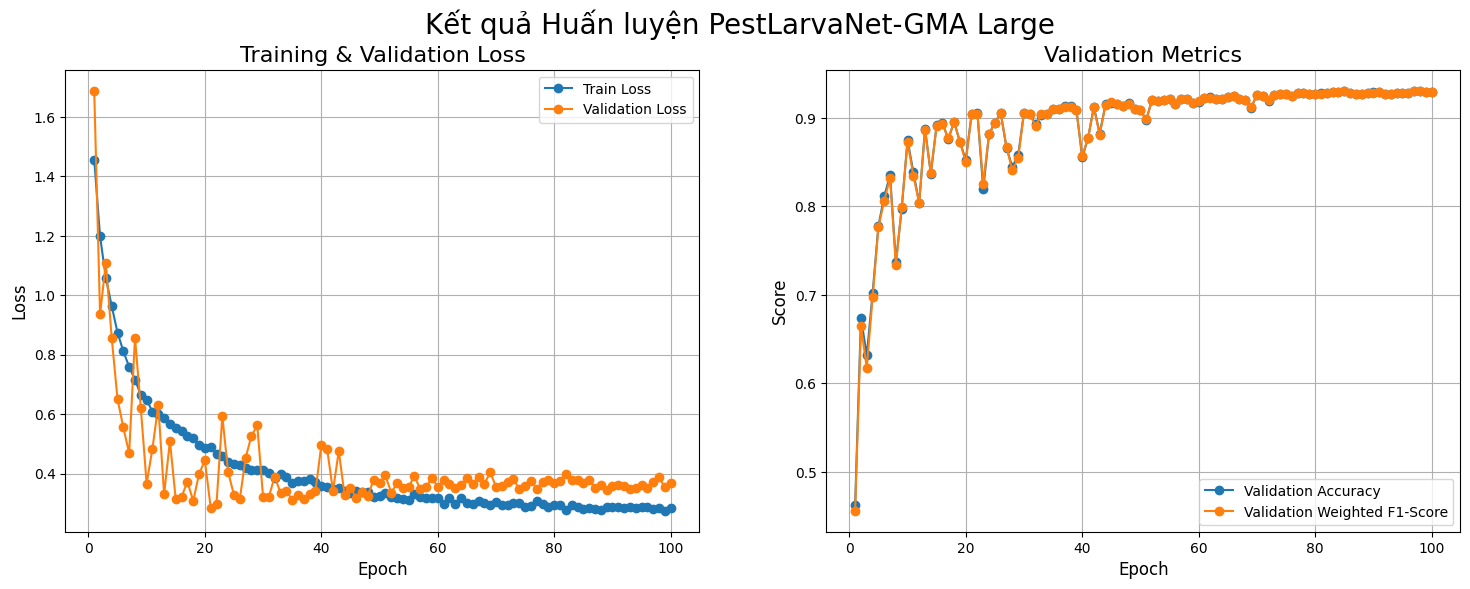

C:\Users\Deltax\AppData\Local\Temp\ipykernel_20240\2414344596.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_loca


Tải trọng số model tốt nhất để vẽ Confusion Matrix.


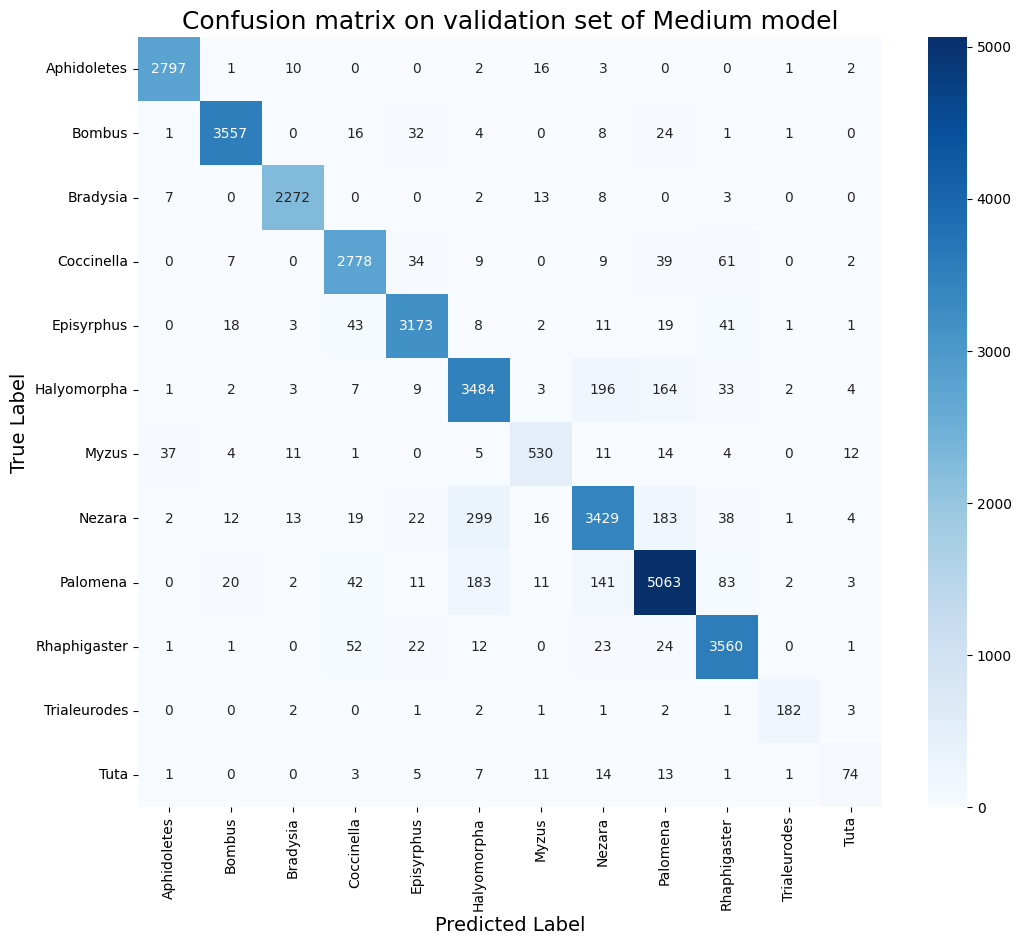

In [18]:
log_df = pd.read_csv(LOG_CSV_PATH)

# --- Vẽ biểu đồ Loss và Accuracy ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Training & Validation Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(log_df['epoch'], log_df['accuracy'], label='Validation Accuracy', marker='o')
ax2.plot(log_df['epoch'], log_df['weighted_f1'], label='Validation Weighted F1-Score', marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.suptitle('Kết quả Huấn luyện PestLarvaNet-GMA Large', fontsize=20)
plt.show()

# --- Vẽ Ma trận nhầm lẫn (Confusion Matrix) ---
# Tải lại trọng số của model tốt nhất để đánh giá
best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("\nTải trọng số model tốt nhất để vẽ Confusion Matrix.")
    
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.class_names, 
            yticklabels=full_dataset.class_names)
plt.title('Confusion matrix on validation set of Medium model', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()